<a href="https://colab.research.google.com/github/LeoMcBills/100-Days-Of-ML-Code/blob/master/Ronald.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

JAX backend: gpu
JAX devices: [CudaDevice(id=0)]
Running JAX simulations for Question 1 (first run includes JIT compilation)...
--- Simulating Moiety A (Question 1) ---
T1 = 3.000 s, T2 = 0.300 s, M0 = 40.0 A/m
Transforming to Lab Frame for 3D plot...


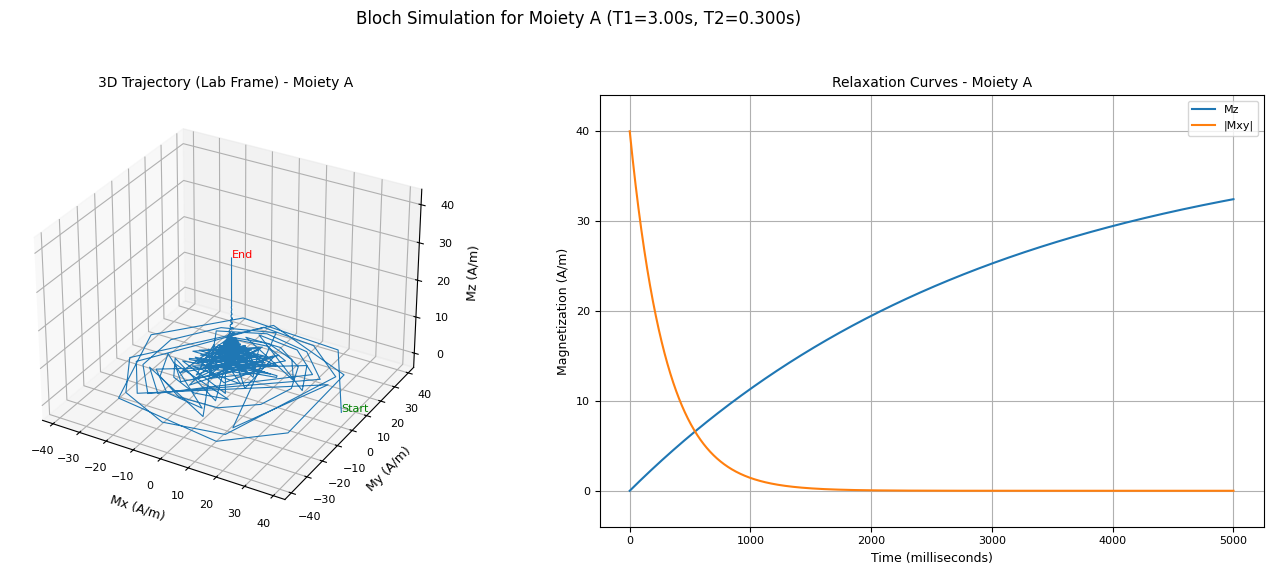

--- Simulating Moiety B (Question 1) ---
T1 = 1.500 s, T2 = 0.100 s, M0 = 40.0 A/m
Transforming to Lab Frame for 3D plot...


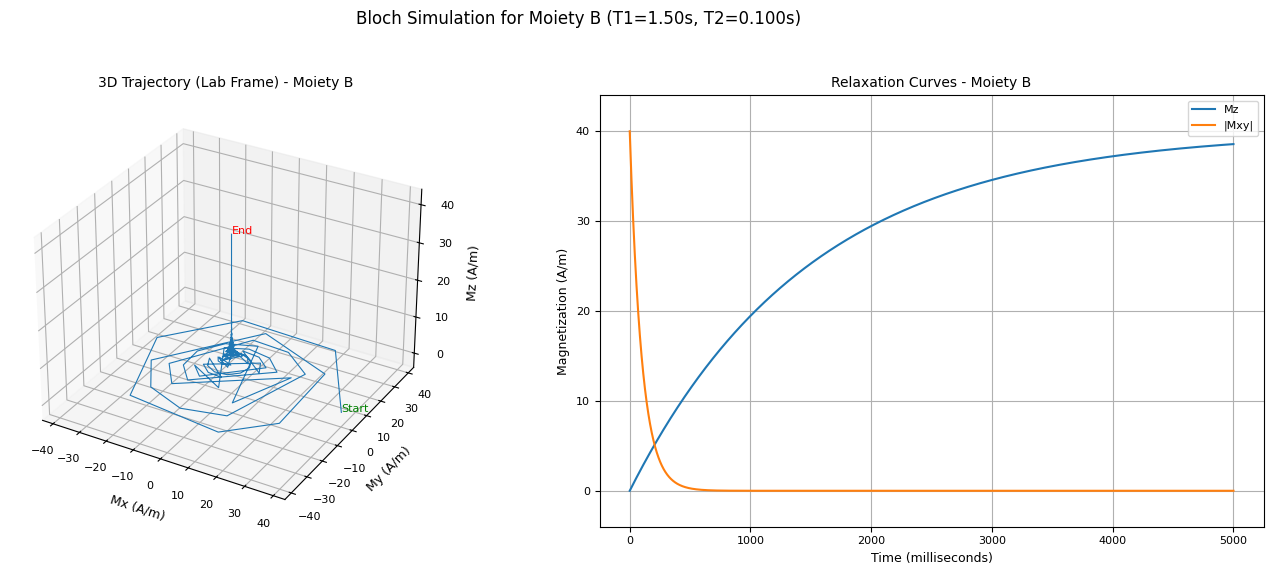

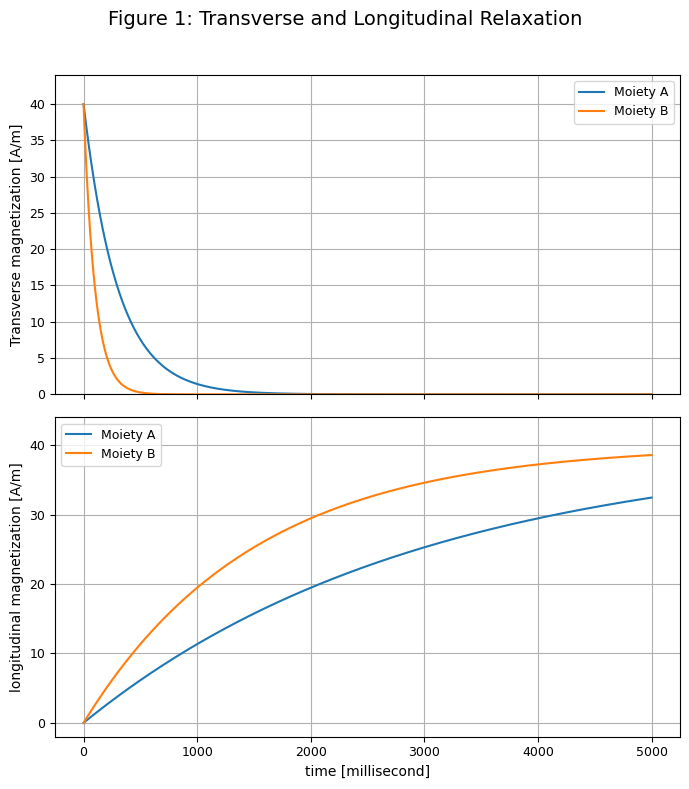


Question 1 Simulation Complete.
Outputs:
- Individual 3D trajectory and relaxation plots for Moiety A.
- Individual 3D trajectory and relaxation plots for Moiety B.
- Combined plot of Mz(t) and |Mxy(t)| for both moieties, styled after Figure 1.

Parameters used:
  gamma/(2*pi) = 42.58 MHz/T
  B0 = 1.0 T
  M0 (initial & equilibrium) = 40.0 A/m
  Moiety A: T1 = 3.0 s, T2 = 0.300 s
  Moiety B: T1 = 1.5 s, T2 = 0.100 s


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# JAX imports
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint # JAX's ODE solver

print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")

# --- Constants from the Prompt ---
GAMMA_OVER_2PI_HZ_PER_T = 42.58e6  # Hz/T
GAMMA_JAX = 2 * jnp.pi * jnp.array(GAMMA_OVER_2PI_HZ_PER_T)  # rad/s/T

B0_FIELD = 1.0  # Tesla (B_0 = 1T)
M0_AMPLITUDE = 40.0  # A/m (Initial magnetization and equilibrium magnitude)

# --- Bloch Equations (Rotating Frame) - JAX compatible ---
@jax.jit
def bloch_equations_rotating_frame_jax(M_prime, t, T1, T2, M0_eq, delta_omega):
    """
    Bloch equations in the rotating frame for JAX's odeint.
    For on-resonance (rotating at Larmor frequency), delta_omega = 0.
    M_prime = [Mx', My', Mz']
    M0_eq is the equilibrium magnetization (scalar, along z)
    """
    Mx_p, My_p, Mz_p = M_prime

    # For on-resonance simulation, delta_omega is 0
    dMx_p_dt = delta_omega * My_p - Mx_p / T2
    dMy_p_dt = -delta_omega * Mx_p - My_p / T2
    dMz_p_dt = -(Mz_p - M0_eq) / T1

    return jnp.array([dMx_p_dt, dMy_p_dt, dMz_p_dt])

# --- Simulation and Plotting Function (Using JAX - ROTATING FRAME) ---
def simulate_moiety_for_assignment(moiety_name, T1_val, T2_val,
                                   M0_initial_val, M0_equilibrium_val,
                                   gamma_val, B0_val,
                                   t_max_sim_s=5.0, num_points_sim=2500, # Increased points for smoother 3D lab plot
                                   plot_lab_frame_3d=True):
    print(f"--- Simulating Moiety {moiety_name} (Question 1) ---")
    print(f"T1 = {T1_val:.3f} s, T2 = {T2_val:.3f} s, M0 = {M0_initial_val:.1f} A/m")

    # Initial conditions for JAX: M(0) = [M0, 0, 0]
    # This represents [Mx', My', Mz'] at t=0 in the rotating frame
    M_initial_jax_rf = jnp.array([M0_initial_val, 0.0, 0.0])

    t_eval_jax = jnp.linspace(0.0, t_max_sim_s, num_points_sim)

    T1_j = jnp.array(T1_val)
    T2_j = jnp.array(T2_val)
    M0_eq_j = jnp.array(M0_equilibrium_val)

    # On-resonance: delta_omega = (gamma * B0_effective) - omega_rotation_frame = 0
    # Here, B0_effective is just B0.
    # We are solving in a frame rotating at omega_Larmor, so delta_omega = 0.
    delta_omega_j = jnp.array(0.0)

    # Solve ODEs using JAX's odeint with the rotating frame equations
    sol_M_rf = odeint(bloch_equations_rotating_frame_jax, M_initial_jax_rf, t_eval_jax,
                      T1_j, T2_j, M0_eq_j, delta_omega_j)

    Mx_rf = sol_M_rf[:, 0]
    My_rf = sol_M_rf[:, 1]
    Mz_rf = sol_M_rf[:, 2] # Mz_rf is same as Mz_lab

    t_eval_np = np.array(t_eval_jax)
    Mx_rf_np = np.array(Mx_rf)
    My_rf_np = np.array(My_rf)
    Mz_np = np.array(Mz_rf)

    M_transverse_mag_np = np.sqrt(Mx_rf_np**2 + My_rf_np**2)

    # --- Plotting ---
    fig = plt.figure(figsize=(14, 6))

    # 3D Plot
    ax1 = fig.add_subplot(121, projection='3d')
    plot_skip = max(1, len(t_eval_np) // 1000) # Keep plot responsive

    if plot_lab_frame_3d:
        print("Transforming to Lab Frame for 3D plot...")
        omega0_val = gamma_val * B0_val # Larmor frequency in rad/s
        # Ensure JAX arrays for transformation
        omega0_j_calc = jnp.array(omega0_val)
        cos_omega_t = jnp.cos(omega0_j_calc * t_eval_jax)
        sin_omega_t = jnp.sin(omega0_j_calc * t_eval_jax)

        Mx_lab = Mx_rf * cos_omega_t - My_rf * sin_omega_t
        My_lab = Mx_rf * sin_omega_t + My_rf * cos_omega_t
        # Mz is the same in lab and rotating frame

        Mx_lab_np = np.array(Mx_lab)
        My_lab_np = np.array(My_lab)
        # Mz_lab_np = Mz_np # Mz is already in np format

        ax1.plot(Mx_lab_np[::plot_skip], My_lab_np[::plot_skip], Mz_np[::plot_skip], lw=0.8)
        ax1.set_title(f"3D Trajectory (Lab Frame) - Moiety {moiety_name}", fontsize=10)
        ax1.text(Mx_lab_np[0], My_lab_np[0], Mz_np[0], "Start", color='green', fontsize=8)
        ax1.text(Mx_lab_np[-1], My_lab_np[-1], Mz_np[-1], "End", color='red', fontsize=8)
    else:
        ax1.plot(Mx_rf_np[::plot_skip], My_rf_np[::plot_skip], Mz_np[::plot_skip], lw=1)
        ax1.set_title(f"3D Trajectory (Rotating Frame) - Moiety {moiety_name}", fontsize=10)
        ax1.text(Mx_rf_np[0], My_rf_np[0], Mz_np[0], "Start", color='green', fontsize=8)
        ax1.text(Mx_rf_np[-1], My_rf_np[-1], Mz_np[-1], "End", color='red', fontsize=8)

    ax1.set_xlabel("Mx (A/m)", fontsize=9); ax1.set_ylabel("My (A/m)", fontsize=9); ax1.set_zlabel("Mz (A/m)", fontsize=9)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.set_xlim([-M0_equilibrium_val*1.1, M0_equilibrium_val*1.1])
    ax1.set_ylim([-M0_equilibrium_val*1.1, M0_equilibrium_val*1.1])
    min_mz_val = np.min(Mz_np)
    ax1.set_zlim([min(0, min_mz_val)*1.1 if min_mz_val < 0 else -0.1*M0_equilibrium_val, # allow slight negative for Mz=0 start
                  M0_equilibrium_val*1.1])


    # 2D Relaxation Curves Plot
    ax2 = fig.add_subplot(122)
    ax2.plot(t_eval_np * 1000, Mz_np, label=f'Mz')
    ax2.plot(t_eval_np * 1000, M_transverse_mag_np, label=f'|Mxy|')
    ax2.set_xlabel("Time (milliseconds)", fontsize=9)
    ax2.set_ylabel("Magnetization (A/m)", fontsize=9)
    ax2.set_title(f"Relaxation Curves - Moiety {moiety_name}", fontsize=10)
    ax2.legend(fontsize=8); ax2.grid(True)
    ax2.tick_params(axis='both', which='major', labelsize=8)
    ax2.set_ylim(-0.1*M0_equilibrium_val, M0_equilibrium_val * 1.1)


    plt.suptitle(f"Bloch Simulation for Moiety {moiety_name} (T1={T1_val:.2f}s, T2={T2_val:.3f}s)", fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    # For the combined plot later, we need t_eval_np, Mz_np, M_transverse_mag_np
    if plot_lab_frame_3d:
        return t_eval_np, Mx_lab_np, My_lab_np, Mz_np, M_transverse_mag_np
    else: # Should not happen with current settings for assignment
        return t_eval_np, Mx_rf_np, My_rf_np, Mz_np, M_transverse_mag_np

# --- Parameters for Moieties from Prompt ---
# Moiety A: T1=3s and T2=300ms
params_A = {'name': 'A', 'T1': 3.0, 'T2': 0.300}
# Moiety B: T1=1.5s and T2=100ms
params_B = {'name': 'B', 'T1': 1.5, 'T2': 0.100}

# --- Run Simulations for each Moiety (Individual Plots) ---
print("Running JAX simulations for Question 1 (first run includes JIT compilation)...")

# Moiety A
t_A_s, Mx_A_lab, My_A_lab, Mz_A_lab, Mxy_mag_A = simulate_moiety_for_assignment(
    params_A['name'], params_A['T1'], params_A['T2'],
    M0_initial_val=M0_AMPLITUDE,
    M0_equilibrium_val=M0_AMPLITUDE, # Relaxes towards M0 along z
    gamma_val=GAMMA_JAX, B0_val=B0_FIELD,
    t_max_sim_s=5.0, # 5000 ms
    plot_lab_frame_3d=True # Required by prompt
)

# Moiety B
t_B_s, Mx_B_lab, My_B_lab, Mz_B_lab, Mxy_mag_B = simulate_moiety_for_assignment(
    params_B['name'], params_B['T1'], params_B['T2'],
    M0_initial_val=M0_AMPLITUDE,
    M0_equilibrium_val=M0_AMPLITUDE, # Relaxes towards M0 along z
    gamma_val=GAMMA_JAX, B0_val=B0_FIELD,
    t_max_sim_s=5.0, # 5000 ms
    plot_lab_frame_3d=True # Required by prompt
)

# --- Combined Plots (as in Figure 1 of the prompt) ---
time_A_ms = t_A_s * 1000
time_B_ms = t_B_s * 1000 # Should be same as t_A_s if parameters are consistent

fig_combined, (ax_trans_combined, ax_long_combined) = plt.subplots(2, 1, figsize=(7, 8), sharex=True)
fig_combined.suptitle("Figure 1: Transverse and Longitudinal Relaxation", fontsize=14)

# Transverse Relaxation Plot
ax_trans_combined.plot(time_A_ms, Mxy_mag_A, label='Moiety A')
ax_trans_combined.plot(time_B_ms, Mxy_mag_B, label='Moiety B')
ax_trans_combined.set_ylabel("Transverse magnetization [A/m]", fontsize=10)
# ax_trans_combined.set_title("Transverse Relaxation |Mxy|", fontsize=11) # Title from figure caption
ax_trans_combined.legend(fontsize=9); ax_trans_combined.grid(True)
ax_trans_combined.set_ylim(0, M0_AMPLITUDE * 1.1)
ax_trans_combined.tick_params(axis='both', which='major', labelsize=9)


# Longitudinal Relaxation Plot
ax_long_combined.plot(time_A_ms, Mz_A_lab, label='Moiety A')
ax_long_combined.plot(time_B_ms, Mz_B_lab, label='Moiety B')
ax_long_combined.set_xlabel("time [millisecond]", fontsize=10)
ax_long_combined.set_ylabel("longitudinal magnetization [A/m]", fontsize=10) # Lowercase as in prompt's fig
# ax_long_combined.set_title("Longitudinal Relaxation Mz", fontsize=11) # Title from figure caption
ax_long_combined.legend(fontsize=9); ax_long_combined.grid(True)
min_mz_overall = min(np.min(Mz_A_lab), np.min(Mz_B_lab))
ax_long_combined.set_ylim([min(0, min_mz_overall)*1.1 if min_mz_overall < 0 else -0.05*M0_AMPLITUDE, # Allow slight negative for Mz=0 start
                           M0_AMPLITUDE * 1.1])
ax_long_combined.tick_params(axis='both', which='major', labelsize=9)


plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
plt.show()

print("\nQuestion 1 Simulation Complete.")
print("Outputs:")
print("- Individual 3D trajectory and relaxation plots for Moiety A.")
print("- Individual 3D trajectory and relaxation plots for Moiety B.")
print("- Combined plot of Mz(t) and |Mxy(t)| for both moieties, styled after Figure 1.")
print(f"\nParameters used:")
print(f"  gamma/(2*pi) = {GAMMA_OVER_2PI_HZ_PER_T/1e6:.2f} MHz/T")
print(f"  B0 = {B0_FIELD:.1f} T")
print(f"  M0 (initial & equilibrium) = {M0_AMPLITUDE:.1f} A/m")
print(f"  Moiety A: T1 = {params_A['T1']:.1f} s, T2 = {params_A['T2']:.3f} s")
print(f"  Moiety B: T1 = {params_B['T1']:.1f} s, T2 = {params_B['T2']:.3f} s")

JAX backend: gpu
JAX devices: [CudaDevice(id=0)]
Running JAX simulations for Question 1 (first run includes JIT compilation)...
--- Simulating Moiety A (Question 1) ---
T1 = 3.000 s, T2 = 0.300 s, M0 = 40.0 A/m
Simulating for 5.0 s with 2500 points.
Transforming to Lab Frame for 3D plot...


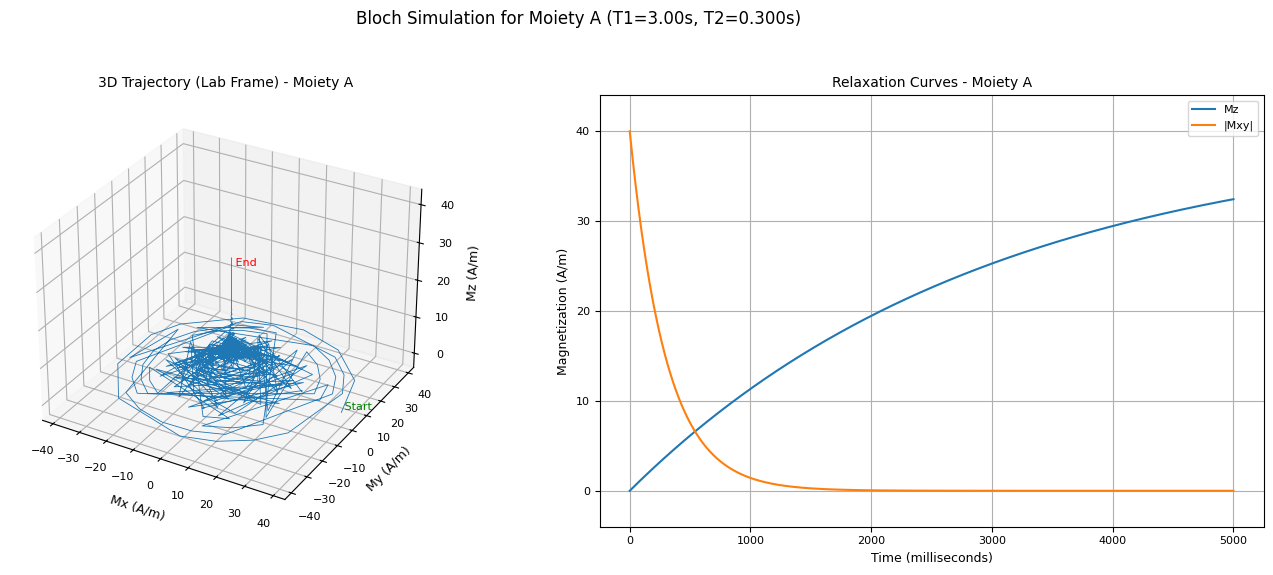

--- Simulating Moiety B (Question 1) ---
T1 = 1.500 s, T2 = 0.100 s, M0 = 40.0 A/m
Simulating for 5.0 s with 2500 points.
Transforming to Lab Frame for 3D plot...


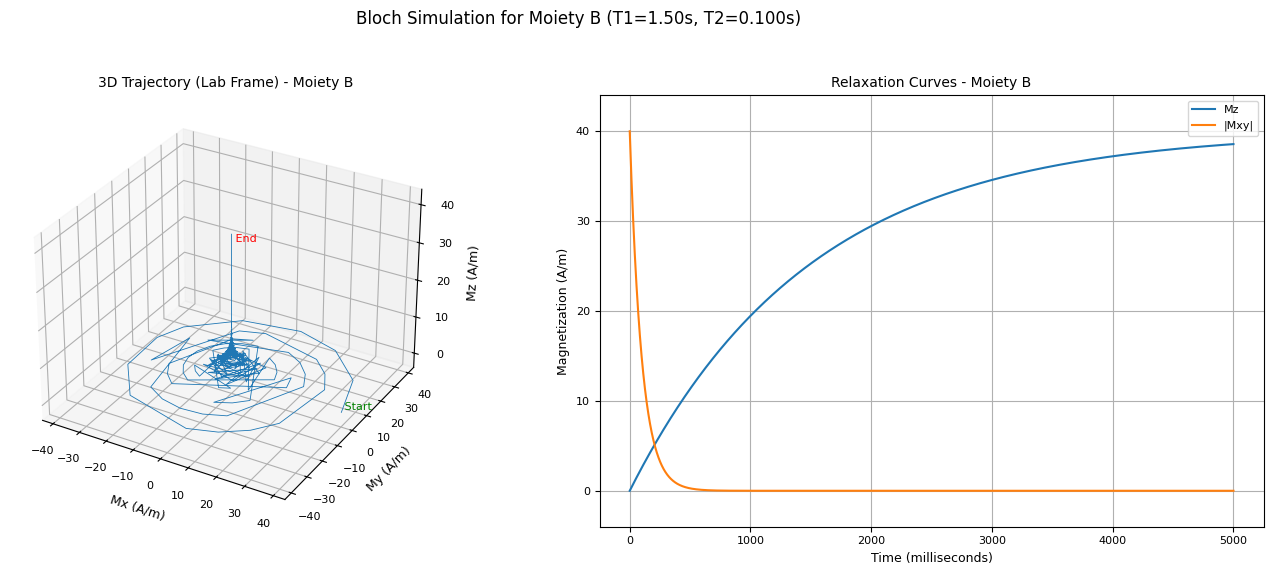

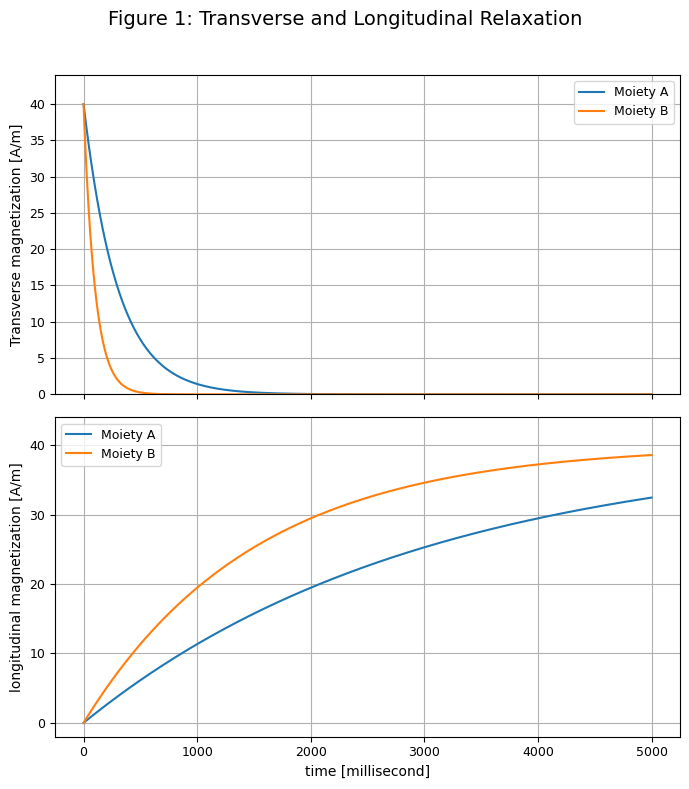


Question 1 Simulation Complete.
Outputs:
- Individual 3D trajectory and relaxation plots for Moiety A.
- Individual 3D trajectory and relaxation plots for Moiety B.
- Combined plot of Mz(t) and |Mxy(t)| for both moieties, styled after Figure 1.

Parameters used:
  gamma/(2*pi) = 42.58 MHz/T
  B0 = 1.0 T
  M0 (initial & equilibrium) = 40.0 A/m
  Moiety A: T1 = 3.0 s, T2 = 0.300 s
  Moiety B: T1 = 1.5 s, T2 = 0.100 s


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# JAX imports
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint # JAX's ODE solver

print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")

# --- Constants from the Prompt ---
GAMMA_OVER_2PI_HZ_PER_T = 42.58e6  # Hz/T
GAMMA_JAX = 2 * jnp.pi * jnp.array(GAMMA_OVER_2PI_HZ_PER_T)  # rad/s/T

B0_FIELD = 1.0  # Tesla (B_0 = 1T)
M0_AMPLITUDE = 40.0  # A/m (Initial magnetization and equilibrium magnitude)

# --- Bloch Equations (Rotating Frame) - JAX compatible ---
@jax.jit
def bloch_equations_rotating_frame_jax(M_prime, t, T1, T2, M0_eq, delta_omega):
    """
    Bloch equations in the rotating frame for JAX's odeint.
    For on-resonance (rotating at Larmor frequency), delta_omega = 0.
    M_prime = [Mx', My', Mz']
    M0_eq is the equilibrium magnetization (scalar, along z)
    """
    Mx_p, My_p, Mz_p = M_prime

    # For on-resonance simulation, delta_omega is 0
    dMx_p_dt = delta_omega * My_p - Mx_p / T2
    dMy_p_dt = -delta_omega * Mx_p - My_p / T2
    dMz_p_dt = -(Mz_p - M0_eq) / T1

    return jnp.array([dMx_p_dt, dMy_p_dt, dMz_p_dt])

# --- Simulation and Plotting Function (Using JAX - ROTATING FRAME) ---
def simulate_moiety_for_assignment(moiety_name, T1_val, T2_val,
                                   M0_initial_val, M0_equilibrium_val,
                                   gamma_val, B0_val,
                                   t_max_sim_s=5.0, num_points_sim=2500,
                                   plot_lab_frame_3d=True):
    print(f"--- Simulating Moiety {moiety_name} (Question 1) ---")
    print(f"T1 = {T1_val:.3f} s, T2 = {T2_val:.3f} s, M0 = {M0_initial_val:.1f} A/m")
    print(f"Simulating for {t_max_sim_s:.1f} s with {num_points_sim} points.")

    M_initial_jax_rf = jnp.array([M0_initial_val, 0.0, 0.0])
    t_eval_jax = jnp.linspace(0.0, t_max_sim_s, num_points_sim)

    T1_j = jnp.array(T1_val)
    T2_j = jnp.array(T2_val)
    M0_eq_j = jnp.array(M0_equilibrium_val)
    delta_omega_j = jnp.array(0.0) # On-resonance

    sol_M_rf = odeint(bloch_equations_rotating_frame_jax, M_initial_jax_rf, t_eval_jax,
                      T1_j, T2_j, M0_eq_j, delta_omega_j)

    Mx_rf = sol_M_rf[:, 0]
    My_rf = sol_M_rf[:, 1]
    Mz_rf = sol_M_rf[:, 2]

    t_eval_np = np.array(t_eval_jax)
    Mx_rf_np = np.array(Mx_rf)
    My_rf_np = np.array(My_rf)
    Mz_np = np.array(Mz_rf)

    M_transverse_mag_np = np.sqrt(Mx_rf_np**2 + My_rf_np**2)

    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(121, projection='3d')

    # For the 3D lab frame plot, we will use all points from the ODE solution
    # to get the densest possible trace for the given num_points_sim.
    plot_skip_for_3d_plot = 1

    if plot_lab_frame_3d:
        print("Transforming to Lab Frame for 3D plot...")
        omega0_val = gamma_val * B0_val
        omega0_j_calc = jnp.array(omega0_val)
        cos_omega_t = jnp.cos(omega0_j_calc * t_eval_jax)
        sin_omega_t = jnp.sin(omega0_j_calc * t_eval_jax)

        Mx_lab = Mx_rf * cos_omega_t - My_rf * sin_omega_t
        My_lab = Mx_rf * sin_omega_t + My_rf * cos_omega_t

        Mx_lab_np = np.array(Mx_lab)
        My_lab_np = np.array(My_lab)

        ax1.plot(Mx_lab_np[::plot_skip_for_3d_plot], My_lab_np[::plot_skip_for_3d_plot], Mz_np[::plot_skip_for_3d_plot], lw=0.6) # Reduced line width
        ax1.set_title(f"3D Trajectory (Lab Frame) - Moiety {moiety_name}", fontsize=10)
        ax1.text(Mx_lab_np[0], My_lab_np[0], Mz_np[0], " Start", color='green', fontsize=8, ha='left', va='bottom')
        ax1.text(Mx_lab_np[-1], My_lab_np[-1], Mz_np[-1], " End", color='red', fontsize=8, ha='left', va='top')
    else: # Plotting rotating frame (will be a smooth spiral, no fast precession)
        ax1.plot(Mx_rf_np[::plot_skip_for_3d_plot], My_rf_np[::plot_skip_for_3d_plot], Mz_np[::plot_skip_for_3d_plot], lw=1)
        ax1.set_title(f"3D Trajectory (Rotating Frame) - Moiety {moiety_name}", fontsize=10)
        ax1.text(Mx_rf_np[0], My_rf_np[0], Mz_np[0], " Start", color='green', fontsize=8, ha='left', va='bottom')
        ax1.text(Mx_rf_np[-1], My_rf_np[-1], Mz_np[-1], " End", color='red', fontsize=8, ha='left', va='top')

    ax1.set_xlabel("Mx (A/m)", fontsize=9); ax1.set_ylabel("My (A/m)", fontsize=9); ax1.set_zlabel("Mz (A/m)", fontsize=9)
    ax1.tick_params(axis='both', which='major', labelsize=8)
    ax1.set_xlim([-M0_equilibrium_val*1.1, M0_equilibrium_val*1.1])
    ax1.set_ylim([-M0_equilibrium_val*1.1, M0_equilibrium_val*1.1])
    min_mz_val = np.min(Mz_np)
    ax1.set_zlim([min(0, min_mz_val)*1.1 if min_mz_val < 0 else -0.1*M0_equilibrium_val,
                  M0_equilibrium_val*1.1])

    ax2 = fig.add_subplot(122)
    ax2.plot(t_eval_np * 1000, Mz_np, label=f'Mz')
    ax2.plot(t_eval_np * 1000, M_transverse_mag_np, label=f'|Mxy|')
    ax2.set_xlabel("Time (milliseconds)", fontsize=9)
    ax2.set_ylabel("Magnetization (A/m)", fontsize=9)
    ax2.set_title(f"Relaxation Curves - Moiety {moiety_name}", fontsize=10)
    ax2.legend(fontsize=8); ax2.grid(True)
    ax2.tick_params(axis='both', which='major', labelsize=8)
    ax2.set_ylim(-0.1*M0_equilibrium_val, M0_equilibrium_val * 1.1)

    plt.suptitle(f"Bloch Simulation for Moiety {moiety_name} (T1={T1_val:.2f}s, T2={T2_val:.3f}s)", fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    if plot_lab_frame_3d:
        return t_eval_np, Mx_lab_np, My_lab_np, Mz_np, M_transverse_mag_np
    else:
        return t_eval_np, Mx_rf_np, My_rf_np, Mz_np, M_transverse_mag_np

# --- Parameters for Moieties from Prompt ---
params_A = {'name': 'A', 'T1': 3.0, 'T2': 0.300}
params_B = {'name': 'B', 'T1': 1.5, 'T2': 0.100}

# --- Run Simulations for each Moiety (Individual Plots) ---
print("Running JAX simulations for Question 1 (first run includes JIT compilation)...")

# Moiety A
# You can increase num_points_sim here (e.g., to 5000 or 10000) for a denser 3D scribble.
# Default is 2500 for reasonable speed.
t_A_s, Mx_A_lab, My_A_lab, Mz_A_lab, Mxy_mag_A = simulate_moiety_for_assignment(
    params_A['name'], params_A['T1'], params_A['T2'],
    M0_initial_val=M0_AMPLITUDE,
    M0_equilibrium_val=M0_AMPLITUDE,
    gamma_val=GAMMA_JAX, B0_val=B0_FIELD,
    t_max_sim_s=5.0,
    num_points_sim=2500, # Default, can be increased for denser 3D trace
    plot_lab_frame_3d=True
)

# Moiety B
t_B_s, Mx_B_lab, My_B_lab, Mz_B_lab, Mxy_mag_B = simulate_moiety_for_assignment(
    params_B['name'], params_B['T1'], params_B['T2'],
    M0_initial_val=M0_AMPLITUDE,
    M0_equilibrium_val=M0_AMPLITUDE,
    gamma_val=GAMMA_JAX, B0_val=B0_FIELD,
    t_max_sim_s=5.0,
    num_points_sim=2500, # Default, can be increased for denser 3D trace
    plot_lab_frame_3d=True
)

# --- Combined Plots (as in Figure 1 of the prompt) ---
time_A_ms = t_A_s * 1000
time_B_ms = t_B_s * 1000

fig_combined, (ax_trans_combined, ax_long_combined) = plt.subplots(2, 1, figsize=(7, 8), sharex=True)
fig_combined.suptitle("Figure 1: Transverse and Longitudinal Relaxation", fontsize=14)

ax_trans_combined.plot(time_A_ms, Mxy_mag_A, label='Moiety A')
ax_trans_combined.plot(time_B_ms, Mxy_mag_B, label='Moiety B')
ax_trans_combined.set_ylabel("Transverse magnetization [A/m]", fontsize=10)
ax_trans_combined.legend(fontsize=9); ax_trans_combined.grid(True)
ax_trans_combined.set_ylim(0, M0_AMPLITUDE * 1.1)
ax_trans_combined.tick_params(axis='both', which='major', labelsize=9)

ax_long_combined.plot(time_A_ms, Mz_A_lab, label='Moiety A')
ax_long_combined.plot(time_B_ms, Mz_B_lab, label='Moiety B')
ax_long_combined.set_xlabel("time [millisecond]", fontsize=10)
ax_long_combined.set_ylabel("longitudinal magnetization [A/m]", fontsize=10)
ax_long_combined.legend(fontsize=9); ax_long_combined.grid(True)
min_mz_overall = min(np.min(Mz_A_lab), np.min(Mz_B_lab))
ax_long_combined.set_ylim([min(0, min_mz_overall)*1.1 if min_mz_overall < 0 else -0.05*M0_AMPLITUDE,
                           M0_AMPLITUDE * 1.1])
ax_long_combined.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\nQuestion 1 Simulation Complete.")
print("Outputs:")
print("- Individual 3D trajectory and relaxation plots for Moiety A.")
print("- Individual 3D trajectory and relaxation plots for Moiety B.")
print("- Combined plot of Mz(t) and |Mxy(t)| for both moieties, styled after Figure 1.")
print(f"\nParameters used:")
print(f"  gamma/(2*pi) = {GAMMA_OVER_2PI_HZ_PER_T/1e6:.2f} MHz/T")
print(f"  B0 = {B0_FIELD:.1f} T")
print(f"  M0 (initial & equilibrium) = {M0_AMPLITUDE:.1f} A/m")
print(f"  Moiety A: T1 = {params_A['T1']:.1f} s, T2 = {params_A['T2']:.3f} s")
print(f"  Moiety B: T1 = {params_B['T1']:.1f} s, T2 = {params_B['T2']:.3f} s")

In [ ]:
import numpy as np # Still useful for initial arrays, matplotlib
from scipy.integrate import solve_ivp # We'll keep the scipy version for comparison/reference
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# JAX imports
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint # JAX's ODE solver

print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")

# --- Constants ---
GAMMA_OVER_2PI_NP = 42.58e6  # Hz/T (NumPy version for scipy)
GAMMA_NP = 2 * np.pi * GAMMA_OVER_2PI_NP  # rad/s/T (NumPy version for scipy)

GAMMA_OVER_2PI_JAX = jnp.array(42.58e6)  # Hz/T (JAX version)
GAMMA_JAX = 2 * jnp.pi * GAMMA_OVER_2PI_JAX  # rad/s/T (JAX version)


B0_FIELD = 1.0  # Tesla
M0_AMPLITUDE = 40.0  # A/m

# --- Bloch Equations (Lab Frame) - JAX compatible ---
# JAX functions need to be "pure" and work with JAX arrays
@jax.jit # Compile this function with JAX for speed
def bloch_equations_jax(M, t, T1, T2, M0_eq, gamma_jax, B0):
    """
    Bloch equations for JAX's odeint.
    Note: JAX odeint expects `func(y, t, *args)` signature.
    M = [Mx, My, Mz]
    M0_eq is the equilibrium magnetization (scalar, along z)
    """
    Mx, My, Mz = M
    omega0 = gamma_jax * B0

    dMx_dt = omega0 * My - Mx / T2
    dMy_dt = -omega0 * Mx - My / T2
    dMz_dt = -(Mz - M0_eq) / T1

    return jnp.array([dMx_dt, dMy_dt, dMz_dt])

# --- Simulation and Plotting Function (Using JAX) ---
def simulate_moiety_jax(moiety_name, T1_val, T2_val, M0_initial_amplitude, M0_equilibrium,
                        gamma_jax_val, B0_val, t_max_sim=5.0, num_points_sim=2000):
    print(f"--- Simulating Moiety {moiety_name} with JAX ---")
    print(f"T1 = {T1_val:.2f} s, T2 = {T2_val:.3f} s")

    # Initial conditions for JAX (needs to be JAX array)
    M_initial_jax = jnp.array([M0_initial_amplitude, 0.0, 0.0])

    # Time points for JAX (needs to be JAX array)
    t_eval_jax = jnp.linspace(0.0, t_max_sim, num_points_sim)

    # Convert T1, T2, M0_eq to JAX arrays if they aren't already for passing as args
    T1_j = jnp.array(T1_val)
    T2_j = jnp.array(T2_val)
    M0_eq_j = jnp.array(M0_equilibrium)

    # Solve ODEs using JAX's odeint
    # The first run will include JIT compilation time for bloch_equations_jax
    # and potentially for parts of odeint itself.
    sol_M = odeint(bloch_equations_jax, M_initial_jax, t_eval_jax,
                   T1_j, T2_j, M0_eq_j, gamma_jax_val, jnp.array(B0_val))

    # Results are JAX arrays. Convert to NumPy for plotting with Matplotlib.
    Mx = np.array(sol_M[:, 0])
    My = np.array(sol_M[:, 1])
    Mz = np.array(sol_M[:, 2])
    t_eval_np = np.array(t_eval_jax) # For plotting

    M_transverse_mag = np.sqrt(Mx**2 + My**2)

    # --- Plotting (same as before) ---
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    plot_skip = max(1, len(t_eval_np) // 1000)
    ax1.plot(Mx[::plot_skip], My[::plot_skip], Mz[::plot_skip])
    ax1.set_xlabel("Mx (A/m)"); ax1.set_ylabel("My (A/m)"); ax1.set_zlabel("Mz (A/m)")
    ax1.set_title(f"3D Trajectory (JAX) - Moiety {moiety_name}")
    # Basic auto-scaling for limits in 3D
    ax1.set_xlim([-M0_initial_amplitude*1.1, M0_initial_amplitude*1.1])
    ax1.set_ylim([-M0_initial_amplitude*1.1, M0_initial_amplitude*1.1])
    ax1.set_zlim([min(0, np.min(Mz))*1.1 if np.min(Mz) < 0 else 0 , M0_equilibrium*1.1])


    ax2 = fig.add_subplot(122)
    ax2.plot(t_eval_np * 1000, Mz, label=f'Mz (JAX {moiety_name})')
    ax2.plot(t_eval_np * 1000, M_transverse_mag, label=f'|Mxy| (JAX {moiety_name})')
    ax2.set_xlabel("Time (milliseconds)"); ax2.set_ylabel("Magnetization (A/m)")
    ax2.set_title(f"Relaxation Curves (JAX) - Moiety {moiety_name}")
    ax2.legend(); ax2.grid(True)

    plt.tight_layout(); plt.show()

    return t_eval_np, Mx, My, Mz, M_transverse_mag

# --- Parameters for Moieties ---
params_A = {'name': 'A', 'T1': 3.0, 'T2': 0.300}
params_B = {'name': 'B', 'T1': 1.5, 'T2': 0.100}

# --- Run JAX Simulations ---
print("Running JAX simulations (first run includes JIT compilation)...")
# Moiety A with JAX
t_A_jax, Mx_A_jax, My_A_jax, Mz_A_jax, Mxy_mag_A_jax = simulate_moiety_jax(
    params_A['name'], params_A['T1'], params_A['T2'],
    M0_initial_amplitude=M0_AMPLITUDE,
    M0_equilibrium=M0_AMPLITUDE,
    gamma_jax_val=GAMMA_JAX, B0_val=B0_FIELD
)

# Moiety B with JAX
t_B_jax, Mx_B_jax, My_B_jax, Mz_B_jax, Mxy_mag_B_jax = simulate_moiety_jax(
    params_B['name'], params_B['T1'], params_B['T2'],
    M0_initial_amplitude=M0_AMPLITUDE,
    M0_equilibrium=M0_AMPLITUDE,
    gamma_jax_val=GAMMA_JAX, B0_val=B0_FIELD
)

# --- Combined Plots (JAX results) ---
time_ms_jax = t_A_jax * 1000

fig_combined_jax, (ax_trans_jax, ax_long_jax) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

ax_trans_jax.plot(time_ms_jax, Mxy_mag_A_jax, label='Moiety A |Mxy| (JAX)')
ax_trans_jax.plot(time_ms_jax, Mxy_mag_B_jax, label='Moiety B |Mxy| (JAX)')
ax_trans_jax.set_ylabel("Transverse Magnetization |Mxy| (A/m)")
ax_trans_jax.set_title("Transverse Relaxation (JAX)")
ax_trans_jax.legend(); ax_trans_jax.grid(True)
ax_trans_jax.set_ylim(0, M0_AMPLITUDE * 1.1)

ax_long_jax.plot(time_ms_jax, Mz_A_jax, label='Moiety A Mz (JAX)')
ax_long_jax.plot(time_ms_jax, Mz_B_jax, label='Moiety B Mz (JAX)')
ax_long_jax.set_xlabel("Time (milliseconds)")
ax_long_jax.set_ylabel("Longitudinal Magnetization Mz (A/m)")
ax_long_jax.set_title("Longitudinal Relaxation (JAX)")
ax_long_jax.legend(); ax_long_jax.grid(True)
ax_long_jax.set_ylim([min(0, np.min(Mz_A_jax), np.min(Mz_B_jax))*1.1 if min(np.min(Mz_A_jax), np.min(Mz_B_jax)) < 0 else 0,
                  M0_AMPLITUDE * 1.1])

plt.suptitle("Comparison of Moiety A and B Relaxation (JAX)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

JAX backend: gpu
JAX devices: [CudaDevice(id=0)]
Running JAX simulations (first run includes JIT compilation)...
--- Simulating Moiety A with JAX ---
T1 = 3.00 s, T2 = 0.300 s


JAX backend: gpu
JAX devices: [CudaDevice(id=0)]
Running JAX simulations (first run includes JIT compilation)...
--- Simulating Moiety A with JAX (Rotating Frame) ---
T1 = 3.00 s, T2 = 0.300 s


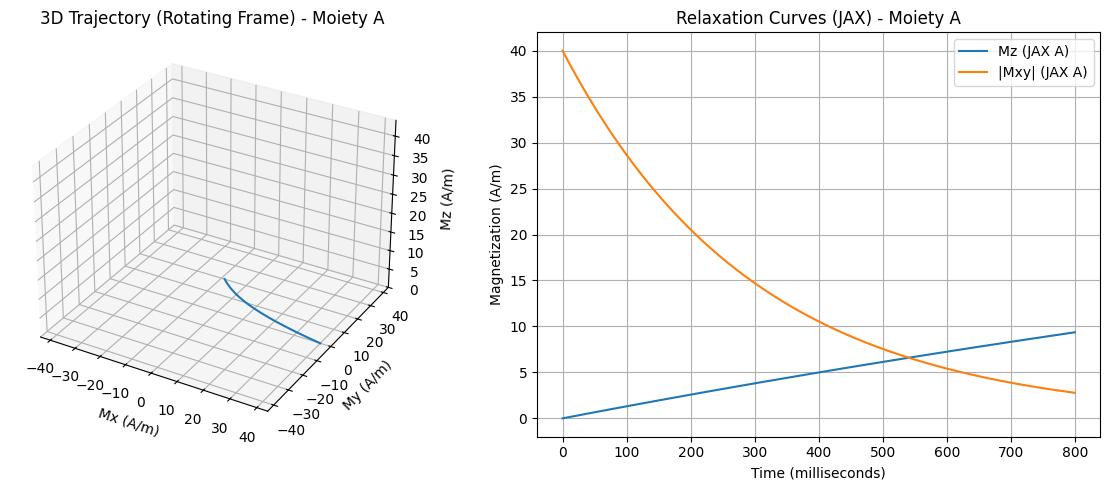

--- Simulating Moiety B with JAX (Rotating Frame) ---
T1 = 1.50 s, T2 = 0.100 s


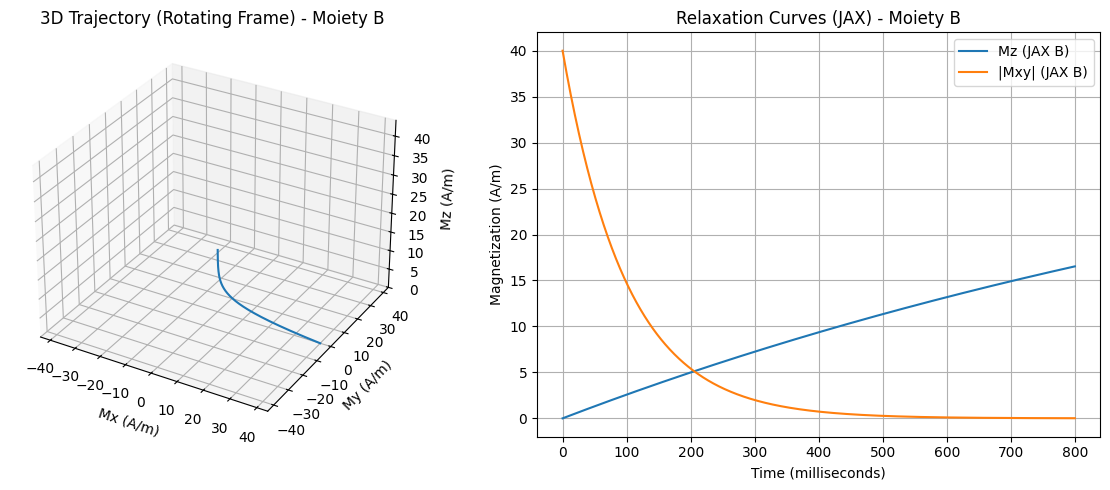

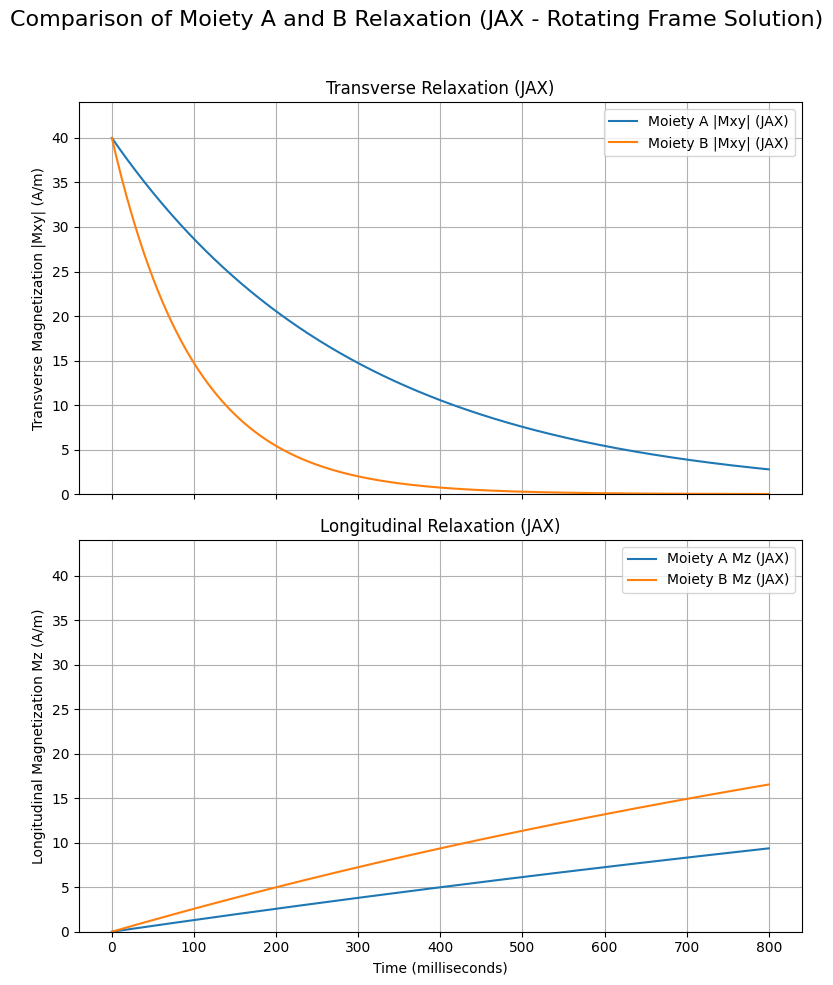

Done.


In [1]:
import numpy as np # Still useful for initial arrays, matplotlib
# from scipy.integrate import solve_ivp # We'll keep the scipy version for comparison/reference
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# JAX imports
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint # JAX's ODE solver

print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")

# --- Constants ---
GAMMA_OVER_2PI_NP = 42.58e6  # Hz/T (NumPy version for scipy)
GAMMA_NP = 2 * np.pi * GAMMA_OVER_2PI_NP  # rad/s/T (NumPy version for scipy)

GAMMA_OVER_2PI_JAX = jnp.array(42.58e6)  # Hz/T (JAX version)
GAMMA_JAX = 2 * jnp.pi * GAMMA_OVER_2PI_JAX  # rad/s/T (JAX version)


B0_FIELD = 1.0  # Tesla
M0_AMPLITUDE = 40.0  # A/m

# --- Bloch Equations (Lab Frame) - JAX compatible ---
# Kept for reference, but WE WILL NOT USE THIS for the fast solution
@jax.jit
def bloch_equations_lab_frame_jax(M, t, T1, T2, M0_eq, gamma_jax, B0):
    Mx, My, Mz = M
    omega0 = gamma_jax * B0
    dMx_dt = omega0 * My - Mx / T2
    dMy_dt = -omega0 * Mx - My / T2
    dMz_dt = -(Mz - M0_eq) / T1
    return jnp.array([dMx_dt, dMy_dt, dMz_dt])

# --- Bloch Equations (Rotating Frame) - JAX compatible ---
@jax.jit # Compile this function with JAX for speed
def bloch_equations_rotating_frame_jax(M_prime, t, T1, T2, M0_eq, delta_omega):
    """
    Bloch equations in the rotating frame for JAX's odeint.
    Assumes rotation at a frequency omega_rot.
    delta_omega = (gamma * B0) - omega_rot.
    For on-resonance (rotating at Larmor frequency), delta_omega = 0.
    M_prime = [Mx', My', Mz']
    M0_eq is the equilibrium magnetization (scalar, along z)
    """
    Mx_p, My_p, Mz_p = M_prime # Mz_p is the same as Mz

    # In the simple case where we rotate at omega0, delta_omega is 0
    # dMx_p_dt = delta_omega * My_p - Mx_p / T2
    # dMy_p_dt = -delta_omega * Mx_p - My_p / T2
    # dMz_p_dt = -(Mz_p - M0_eq) / T1

    # If delta_omega is hardcoded to 0 (rotating exactly at Larmor frequency):
    dMx_p_dt = - Mx_p / T2
    dMy_p_dt = - My_p / T2
    dMz_p_dt = -(Mz_p - M0_eq) / T1

    return jnp.array([dMx_p_dt, dMy_p_dt, dMz_p_dt])


# --- Simulation and Plotting Function (Using JAX - ROTATING FRAME) ---
def simulate_moiety_jax_rotating_frame(moiety_name, T1_val, T2_val, M0_initial_amplitude, M0_equilibrium,
                                       gamma_jax_val, B0_val, t_max_sim=5.0, num_points_sim=2000,
                                       plot_lab_frame_3d=False): # Option to plot lab frame
    print(f"--- Simulating Moiety {moiety_name} with JAX (Rotating Frame) ---")
    print(f"T1 = {T1_val:.2f} s, T2 = {T2_val:.3f} s")

    # Initial conditions for JAX (needs to be JAX array)
    # M_initial_jax represents [Mx', My', Mz'] at t=0
    # If M was along z, then a 90_y pulse flips it to x: M = [M0, 0, 0]
    M_initial_jax_rf = jnp.array([M0_initial_amplitude, 0.0, 0.0])

    # Time points for JAX (needs to be JAX array)
    t_eval_jax = jnp.linspace(0.0, t_max_sim, num_points_sim)

    # Convert T1, T2, M0_eq to JAX arrays
    T1_j = jnp.array(T1_val)
    T2_j = jnp.array(T2_val)
    M0_eq_j = jnp.array(M0_equilibrium)

    # For rotating frame at Larmor frequency, delta_omega = 0
    delta_omega_j = jnp.array(0.0)

    # Solve ODEs using JAX's odeint with the rotating frame equations
    sol_M_rf = odeint(bloch_equations_rotating_frame_jax, M_initial_jax_rf, t_eval_jax,
                      T1_j, T2_j, M0_eq_j, delta_omega_j) # Pass delta_omega instead of gamma and B0

    # Results are JAX arrays.
    Mx_rf = sol_M_rf[:, 0]
    My_rf = sol_M_rf[:, 1]
    Mz_rf = sol_M_rf[:, 2] # Mz_rf is same as Mz_lab

    # Convert to NumPy for plotting with Matplotlib.
    t_eval_np = np.array(t_eval_jax)
    Mx_rf_np = np.array(Mx_rf)
    My_rf_np = np.array(My_rf)
    Mz_np = np.array(Mz_rf) # Mz is same in lab and rotating frame

    M_transverse_mag_np = np.sqrt(Mx_rf_np**2 + My_rf_np**2) # Magnitude is frame-invariant

    # --- Plotting ---
    fig = plt.figure(figsize=(12, 5))

    # 3D Plot
    ax1 = fig.add_subplot(121, projection='3d')
    plot_skip = max(1, len(t_eval_np) // 1000) # Keep plot responsive

    if plot_lab_frame_3d:
        print("Transforming back to Lab Frame for 3D plot...")
        omega0_val = gamma_jax_val * B0_val
        # Ensure omega0_val and t_eval_jax are JAX arrays for JAX operations
        omega0_j = jnp.array(omega0_val)
        # Perform calculations in JAX then convert to numpy
        cos_omega_t = jnp.cos(omega0_j * t_eval_jax)
        sin_omega_t = jnp.sin(omega0_j * t_eval_jax)
        Mx_lab = Mx_rf * cos_omega_t - My_rf * sin_omega_t
        My_lab = Mx_rf * sin_omega_t + My_rf * cos_omega_t
        Mz_lab = Mz_rf # Mz is the same

        Mx_lab_np = np.array(Mx_lab)
        My_lab_np = np.array(My_lab)
        Mz_lab_np = np.array(Mz_lab)

        ax1.plot(Mx_lab_np[::plot_skip], My_lab_np[::plot_skip], Mz_lab_np[::plot_skip])
        ax1.set_title(f"3D Trajectory (Lab Frame from RF) - Moiety {moiety_name}")
    else:
        # Plot rotating frame trajectory (no fast precessions)
        ax1.plot(Mx_rf_np[::plot_skip], My_rf_np[::plot_skip], Mz_np[::plot_skip])
        ax1.set_title(f"3D Trajectory (Rotating Frame) - Moiety {moiety_name}")

    ax1.set_xlabel("Mx (A/m)"); ax1.set_ylabel("My (A/m)"); ax1.set_zlabel("Mz (A/m)")
    ax1.set_xlim([-M0_initial_amplitude*1.1, M0_initial_amplitude*1.1])
    ax1.set_ylim([-M0_initial_amplitude*1.1, M0_initial_amplitude*1.1])
    # Use Mz_np for zlim as it's frame invariant
    min_mz_val = np.min(Mz_np)
    ax1.set_zlim([min(0, min_mz_val)*1.1 if min_mz_val < 0 else 0 , M0_equilibrium*1.1])


    # 2D Relaxation Curves Plot
    ax2 = fig.add_subplot(122)
    ax2.plot(t_eval_np * 1000, Mz_np, label=f'Mz (JAX {moiety_name})')
    ax2.plot(t_eval_np * 1000, M_transverse_mag_np, label=f'|Mxy| (JAX {moiety_name})')
    ax2.set_xlabel("Time (milliseconds)"); ax2.set_ylabel("Magnetization (A/m)")
    ax2.set_title(f"Relaxation Curves (JAX) - Moiety {moiety_name}")
    ax2.legend(); ax2.grid(True)

    plt.tight_layout(); plt.show()

    # Return lab frame components if calculated, otherwise rotating frame
    if plot_lab_frame_3d:
        return t_eval_np, Mx_lab_np, My_lab_np, Mz_lab_np, M_transverse_mag_np
    else:
        return t_eval_np, Mx_rf_np, My_rf_np, Mz_np, M_transverse_mag_np


# --- Parameters for Moieties ---
params_A = {'name': 'A', 'T1': 3.0, 'T2': 0.300}
params_B = {'name': 'B', 'T1': 1.5, 'T2': 0.100}

# --- Run JAX Simulations (Rotating Frame) ---
# Set plot_lab_frame_3d=True if you want to see the spirals, but it will be slower due to
# the post-simulation transformation and plotting many points for the spiral.
# For fastest results and typical relaxation curves, plot_lab_frame_3d=False is fine.
PLOT_LAB_FRAME_SPIRALS = False # TRY SETTING THIS TO TRUE AFTER FIRST RUN

print("Running JAX simulations (first run includes JIT compilation)...")
# Moiety A with JAX
t_A_jax, Mx_A_jax, My_A_jax, Mz_A_jax, Mxy_mag_A_jax = simulate_moiety_jax_rotating_frame(
    params_A['name'], params_A['T1'], params_A['T2'],
    M0_initial_amplitude=M0_AMPLITUDE,
    M0_equilibrium=M0_AMPLITUDE,
    gamma_jax_val=GAMMA_JAX, B0_val=B0_FIELD,
    t_max_sim=0.8, # Reduced Tmax for faster lab frame plotting if enabled
    num_points_sim=1000, # Reduced points for faster lab frame plotting if enabled
    plot_lab_frame_3d=PLOT_LAB_FRAME_SPIRALS
)

# Moiety B with JAX
t_B_jax, Mx_B_jax, My_B_jax, Mz_B_jax, Mxy_mag_B_jax = simulate_moiety_jax_rotating_frame(
    params_B['name'], params_B['T1'], params_B['T2'],
    M0_initial_amplitude=M0_AMPLITUDE,
    M0_equilibrium=M0_AMPLITUDE,
    gamma_jax_val=GAMMA_JAX, B0_val=B0_FIELD,
    t_max_sim=0.8,
    num_points_sim=1000,
    plot_lab_frame_3d=PLOT_LAB_FRAME_SPIRALS
)

# --- Combined Plots (JAX results) ---
# Ensure time vectors are compatible if t_max_sim or num_points_sim differ per moiety
# Here they are the same.
time_ms_jax = t_A_jax * 1000

fig_combined_jax, (ax_trans_jax, ax_long_jax) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

ax_trans_jax.plot(time_ms_jax, Mxy_mag_A_jax, label='Moiety A |Mxy| (JAX)')
ax_trans_jax.plot(time_ms_jax, Mxy_mag_B_jax, label='Moiety B |Mxy| (JAX)')
ax_trans_jax.set_ylabel("Transverse Magnetization |Mxy| (A/m)")
ax_trans_jax.set_title("Transverse Relaxation (JAX)")
ax_trans_jax.legend(); ax_trans_jax.grid(True)
ax_trans_jax.set_ylim(0, M0_AMPLITUDE * 1.1)

ax_long_jax.plot(time_ms_jax, Mz_A_jax, label='Moiety A Mz (JAX)')
ax_long_jax.plot(time_ms_jax, Mz_B_jax, label='Moiety B Mz (JAX)')
ax_long_jax.set_xlabel("Time (milliseconds)")
ax_long_jax.set_ylabel("Longitudinal Magnetization Mz (A/m)")
ax_long_jax.set_title("Longitudinal Relaxation (JAX)")
ax_long_jax.legend(); ax_long_jax.grid(True)
# Determine robust y-limits for Mz plot
min_mz_overall = min(np.min(Mz_A_jax), np.min(Mz_B_jax))
ax_long_jax.set_ylim([min(0, min_mz_overall)*1.1 if min_mz_overall < 0 else 0,
                  M0_AMPLITUDE * 1.1])


plt.suptitle("Comparison of Moiety A and B Relaxation (JAX - Rotating Frame Solution)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

print("Done.")